# Kaggle Project: Titanic Sink 1912 Data Science

## Import Libraries

First of all, we will import the useful packages.

In [2]:
import pandas as pd
import numpy as nu
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

## Load Data

In [11]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]

## Visualize Data

In [28]:
print "Total Training Data Points: {}".format(len(train_df))
print "Total Test Data Points: {}".format(len(test_df))

Total Training Data Points: 714
Total Test Data Points: 418


These are the various columns in our data set:

In [13]:
print train_df.columns.values

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


Let's look at the count of null records in each column.

In [17]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64

As there are lot of empty records in Cabin column, we can ignore the same while building the model.

In [15]:
train_df.drop('Cabin', axis=1, inplace=True)

Further, we see that the ticket number is just an identification and doesn't have in significance in modelling/prediction. Hence, we will ignore this too.

In [18]:
train_df.drop('Ticket', axis=1, inplace=True)

Further 177 records have NaN age, thus we will remove these records.

In [21]:
train_df = train_df[pd.notnull(train_df['Age'])]

This the final information of the train data.

In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 10 columns):
PassengerId    714 non-null int64
Survived       714 non-null int64
Pclass         714 non-null int64
Name           714 non-null object
Sex            714 non-null object
Age            714 non-null float64
SibSp          714 non-null int64
Parch          714 non-null int64
Fare           714 non-null float64
Embarked       712 non-null object
dtypes: float64(2), int64(5), object(3)
memory usage: 61.4+ KB


Now, Let us look at some records in the final dataset.

In [22]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [ ]:
train_df.describe(include=['O'])

Let us observe some correlations. It only makes sense so do so for the data which are either categorical, discrete or ordinal.

In [33]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.655914
1,2,0.479769
2,3,0.239437


In [34]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.754789
1,male,0.205298


In [35]:
train_df[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.530055
2,2,0.440000
0,0,0.371550
3,3,0.333333
4,4,0.166667
5,5,0.000000


In [36]:
train_df[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
2,2,0.573529
1,1,0.554545
0,0,0.357006
5,5,0.200000
4,4,0.000000
6,6,0.000000


From above corrrelations, we observe the following inferences:
1. Passenger Class has direct correlation with the survival, as the passengers of Class 1 have almost 65% rate of survival.
2. Females have more survival rate(~74%) as compared to males.
3. Some categories in SibSp and Parch have 0 correlation with the survival rate.

While, building the model, we will heavily use these outcomes.

Further, we will visualize the data using histograms for continuous variable like Age.

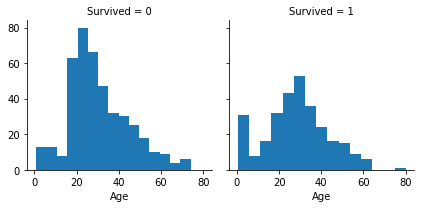

In [40]:
fgrid = sns.FacetGrid(train_df, col='Survived')
fgrid.map(plt.hist, 'Age', bins=15)

Below are the observations from the above histogram:
1. Infants (Age <=4) had high survival rate.
2. Oldest passengers (Age = 80) survived.
3. Large number of 15-25 year olds did not survive.
4. Most passengers are in 15-35 age range.

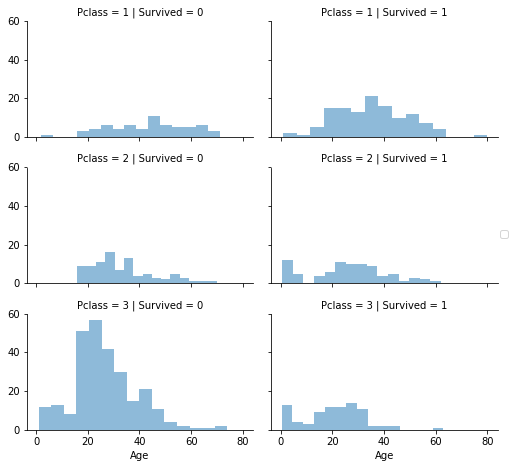

In [43]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=0.5, bins=15)
grid.add_legend()

We see from the Passenger class, Age and Survival histogram that most of the passengers are in class 3 however most of them didn't survive. But if we consider the percentage of passengers, most passengers in class 1 survived. And almost all infants and passengers of age<15 survived in class 2.

Thus Pclass will play a major role in building the model combined with age.

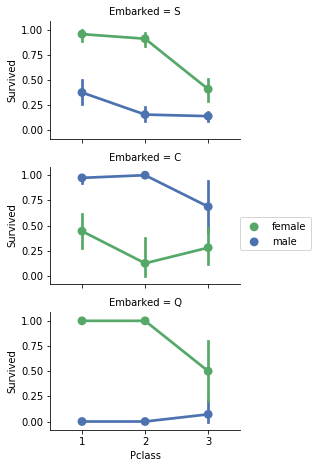

In [47]:
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

Observations:
1. Female passengers had much better survival rate than males.
2. Exception in Embarked=C where males had higher survival rate. This could be a correlation between Pclass and Embarked and in turn Pclass and Survived, not necessarily direct correlation between Embarked and Survived.
3. Males had better survival rate in Pclass=3 when compared with Pclass=2 for C and Q ports.
4. Ports of embarkation have varying survival rates for Pclass=3 and among male passengers.

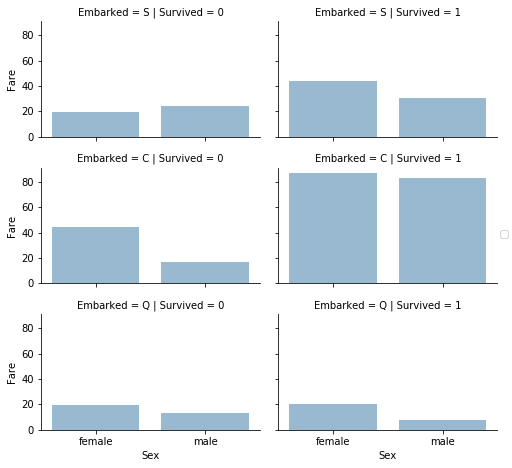

In [49]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=0.5, ci=None)
grid.add_legend()

Observations:
1. Higher fare paying passengers had better survival.
2. Port of embarkation correlates with survival rates.

## Data Engineering and Modification

In [72]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

#pd.crosstab(train_df['Title'], train_df['Sex'])
#train_df.head()

""


In [73]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

ValueError: Cannot convert non-finite values (NA or inf) to integer